In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [5]:
#data_dpath = r'D:\Users\Osnat\Documents\GitHub\ccpa\fcm_and_fl'

data_dpath = r'fcm_and_fl'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]


In [6]:
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    #df = df.melt(id_vars=[ 'Sample', 'PRO', 'ALT', 'EXP', 'METHOD','day'],
        #value_vars=['N', 'P', 'TMM', 'N+P+TMM', 'Control ', 'Transfer to Pro99 1:15'],
        #value_name='FL',
        #var_name ='Mode'
    #            )
    return df

In [7]:
temp_dfs = [_load_fcm_fl_csv(data_dpath, fname) for fname in csv_fnames]
df = pd.concat(temp_dfs)
#df.loc[df.FL < 100, 'FL'] = 0

In [8]:
df.loc[df['MODE']== 'PRO99','MODE'] = 'pro99'

In [9]:
df.loc[df.Sample == '9313 LD_FL1', 'PRO'] = 'MIT9313'

In [10]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN


In [11]:
df.isna().sum()

0
day          0
VALUE        0
EXP          0
METHOD       0
PRO          0
ALT       1071
Sample       0
MODE         0
dtype: int64

In [12]:
df[df.ALT.isna()]['Sample'].unique()

array(['9312 lowN_FCM1', '9312 lowN_FCM2', '9312 lowN_FCM3',
       '9312 lowN_FL1', '9312 lowN_FL2', '9312 lowN_FL3',
       '9312 lowP_FCM1', '9312 lowP_FCM2', '9312 lowP_FCM3',
       '9312 lowP_FL1', '9312 lowP_FL2', '9312 lowP_FL3',
       '9312_PRO99_FCM1', '9312_PRO99_FCM2', '9312_PRO99_FCM3',
       '9312_PRO99_FL1', '9312_PRO99_FL2', '9312_PRO99_FL3',
       '9313 LD_FCM1', '9313 LD_FCM2', '9313 LD_FCM3', '9313 LD_FL1',
       '9313 LD_FL2', '9313 LD_FL3', '9313 lowN_FCM1', '9313 lowN_FCM2',
       '9313 lowN_FCM3', '9313 lowN_FL1', '9313 lowN_FL2',
       '9313 lowN_FL3', '9313 lowP_FCM1', '9313 lowP_FCM2',
       '9313 lowP_FCM3', '9313 lowP_FL1', '9313 lowP_FL2',
       '9313 lowP_FL3', '9313_PRO99_FCM1', '9313_PRO99_FCM2',
       '9313_PRO99_FCM3', '9313_PRO99_FL1', '9313_PRO99_FL2',
       '9313_PRO99_FL3', 'MED4 lowN_FCM1', 'MED4 lowN_FCM2',
       'MED4 lowN_FL1', 'MED4 lowN_FL2', 'MED4 lowN_FL3'], dtype=object)

In [13]:
df = df.fillna({'ALT': 'N/A'}, )

In [14]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN


In [15]:
df.dtypes

0
day       float64
VALUE     float64
EXP        object
METHOD     object
PRO        object
ALT        object
Sample     object
MODE       object
dtype: object

In [16]:
df.isna().sum()

0
day       0
VALUE     0
EXP       0
METHOD    0
PRO       0
ALT       0
Sample    0
MODE      0
dtype: int64

In [17]:
for i in df.columns:
    if i == 'VALUE': 
        continue
    if i == 'day': 
        continue
    print(i, df[i].unique())

EXP ['9312_lowN_1' '9312_lowN_2' '9312_lowN_3' '9312_lowP_1' '9312_lowP_2'
 '9312_lowP_3' '9312_pro99_1' '9312_pro99_2' '9312_pro99_3' '9313_LD_1'
 '9313_LD_2' '9313_LD_3' '9313_lowN_1' '9313_lowN_2' '9313_lowN_3'
 '9313_lowP_1' '9313_lowP_2' '9313_lowP_3' '9313_PRO99_1' '9313_PRO99_2'
 '9313_PRO99_3' 'MED4_lowN_1' 'MED4_lowN_2' 'MED4_lowN_3' 'MED4_1A3_1'
 'MED4_1A3_2' 'MED4_1A3_3']
METHOD ['FCM' 'FL']
PRO ['MIT9312' 'MIT9313' 'MED4']
ALT ['N/A' '1A3']
Sample ['9312 lowN_FCM1' '9312 lowN_FCM2' '9312 lowN_FCM3' '9312 lowN_FL1'
 '9312 lowN_FL2' '9312 lowN_FL3' '9312 lowP_FCM1' '9312 lowP_FCM2'
 '9312 lowP_FCM3' '9312 lowP_FL1' '9312 lowP_FL2' '9312 lowP_FL3'
 '9312_PRO99_FCM1' '9312_PRO99_FCM2' '9312_PRO99_FCM3' '9312_PRO99_FL1'
 '9312_PRO99_FL2' '9312_PRO99_FL3' '9313 LD_FCM1' '9313 LD_FCM2'
 '9313 LD_FCM3' '9313 LD_FL1' '9313 LD_FL2' '9313 LD_FL3' '9313 lowN_FCM1'
 '9313 lowN_FCM2' '9313 lowN_FCM3' '9313 lowN_FL1' '9313 lowN_FL2'
 '9313 lowN_FL3' '9313 lowP_FCM1' '9313 lowP_FCM2' '9313

In [18]:
df['PRO, ALT'] = df.PRO + ', ' +df.ALT

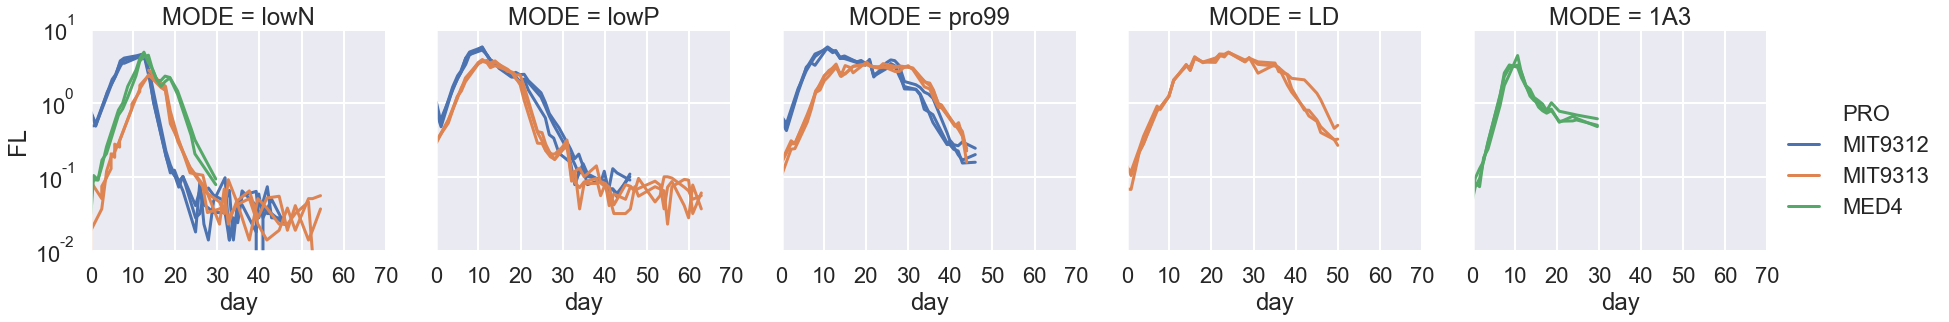

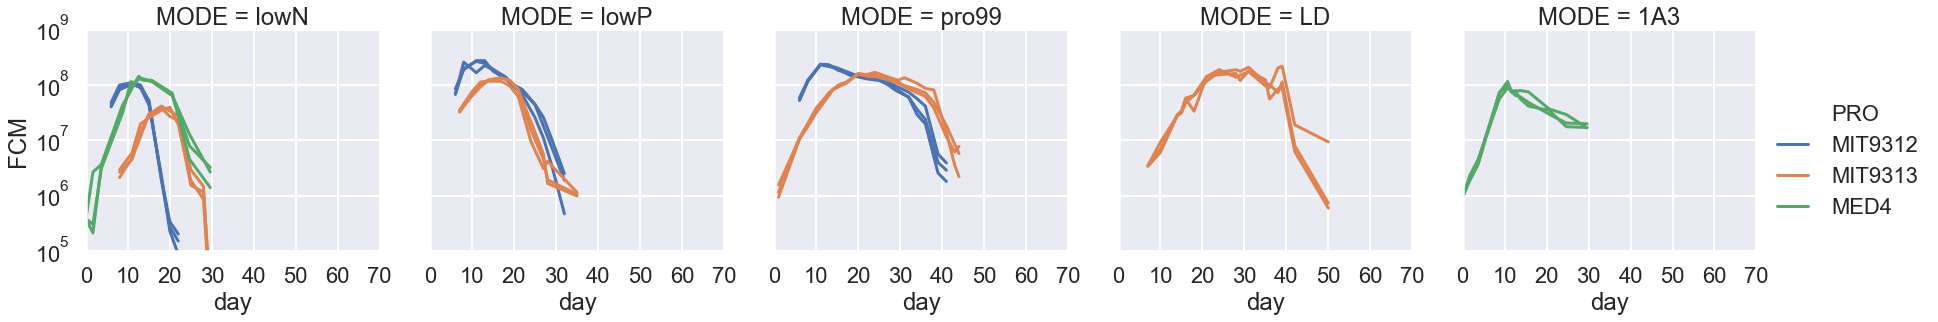

In [19]:
g = sns.relplot(data=df.loc[df.METHOD=='FL'], col='MODE',  hue='PRO',x='day', y='VALUE', 
            kind='line', estimator=None, units='EXP')
g.set(xlim=(0,70), yscale="log", ylabel='FL')
g = sns.relplot(data=df.loc[df.METHOD=='FCM'], col='MODE',  hue='PRO',x='day', y='VALUE', 
            kind='line', estimator=None, units='EXP')
g.set(xlim=(0,70), yscale="log", ylabel='FCM')


In [20]:
df.groupby(['METHOD']).describe()

0         day                                                             \
        count       mean        std  min        25%    50%    75%    max   
METHOD                                                                     
FCM     375.0  19.866817  11.026723  0.0  11.598611  18.00  28.00  50.00   
FL      807.0  23.298033  15.181467  0.0  10.920000  20.97  34.84  62.89   

0       VALUE                                                                \
        count          mean           std    min           25%          50%   
METHOD                                                                        
FCM     375.0  6.992973e+07  6.415715e+07  0.000  8.198314e+06  61312569.52   
FL      807.0  1.439253e+00  1.494861e+00 -0.023  1.050000e-01         0.80   

0                                   
                 75%           max  
METHOD                              
FCM     1.153120e+08  2.754462e+08  
FL      2.606000e+00  5.830000e+00

In [21]:
df.loc[df['MODE'] == 'LD'].groupby(['Sample','PRO']).count()

,,day,VALUE,EXP,METHOD,ALT,MODE,"PRO, ALT"
Sample,PRO,,,,,,,
9313 LD_FCM1,MIT9313,17,17,17,17,17,17,17
9313 LD_FCM2,MIT9313,17,17,17,17,17,17,17
9313 LD_FCM3,MIT9313,17,17,17,17,17,17,17
9313 LD_FL1,MIT9313,29,29,29,29,29,29,29
9313 LD_FL2,MIT9313,29,29,29,29,29,29,29
9313 LD_FL3,MIT9313,29,29,29,29,29,29,29


In [22]:
# (x - x.mean()) / x.std()
df['VALUE_zscore'] = df.groupby('Sample').VALUE.transform(zscore)

In [23]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE,"PRO, ALT",VALUE_zscore
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",-0.155567
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.889925
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.444952
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.076657
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.167816


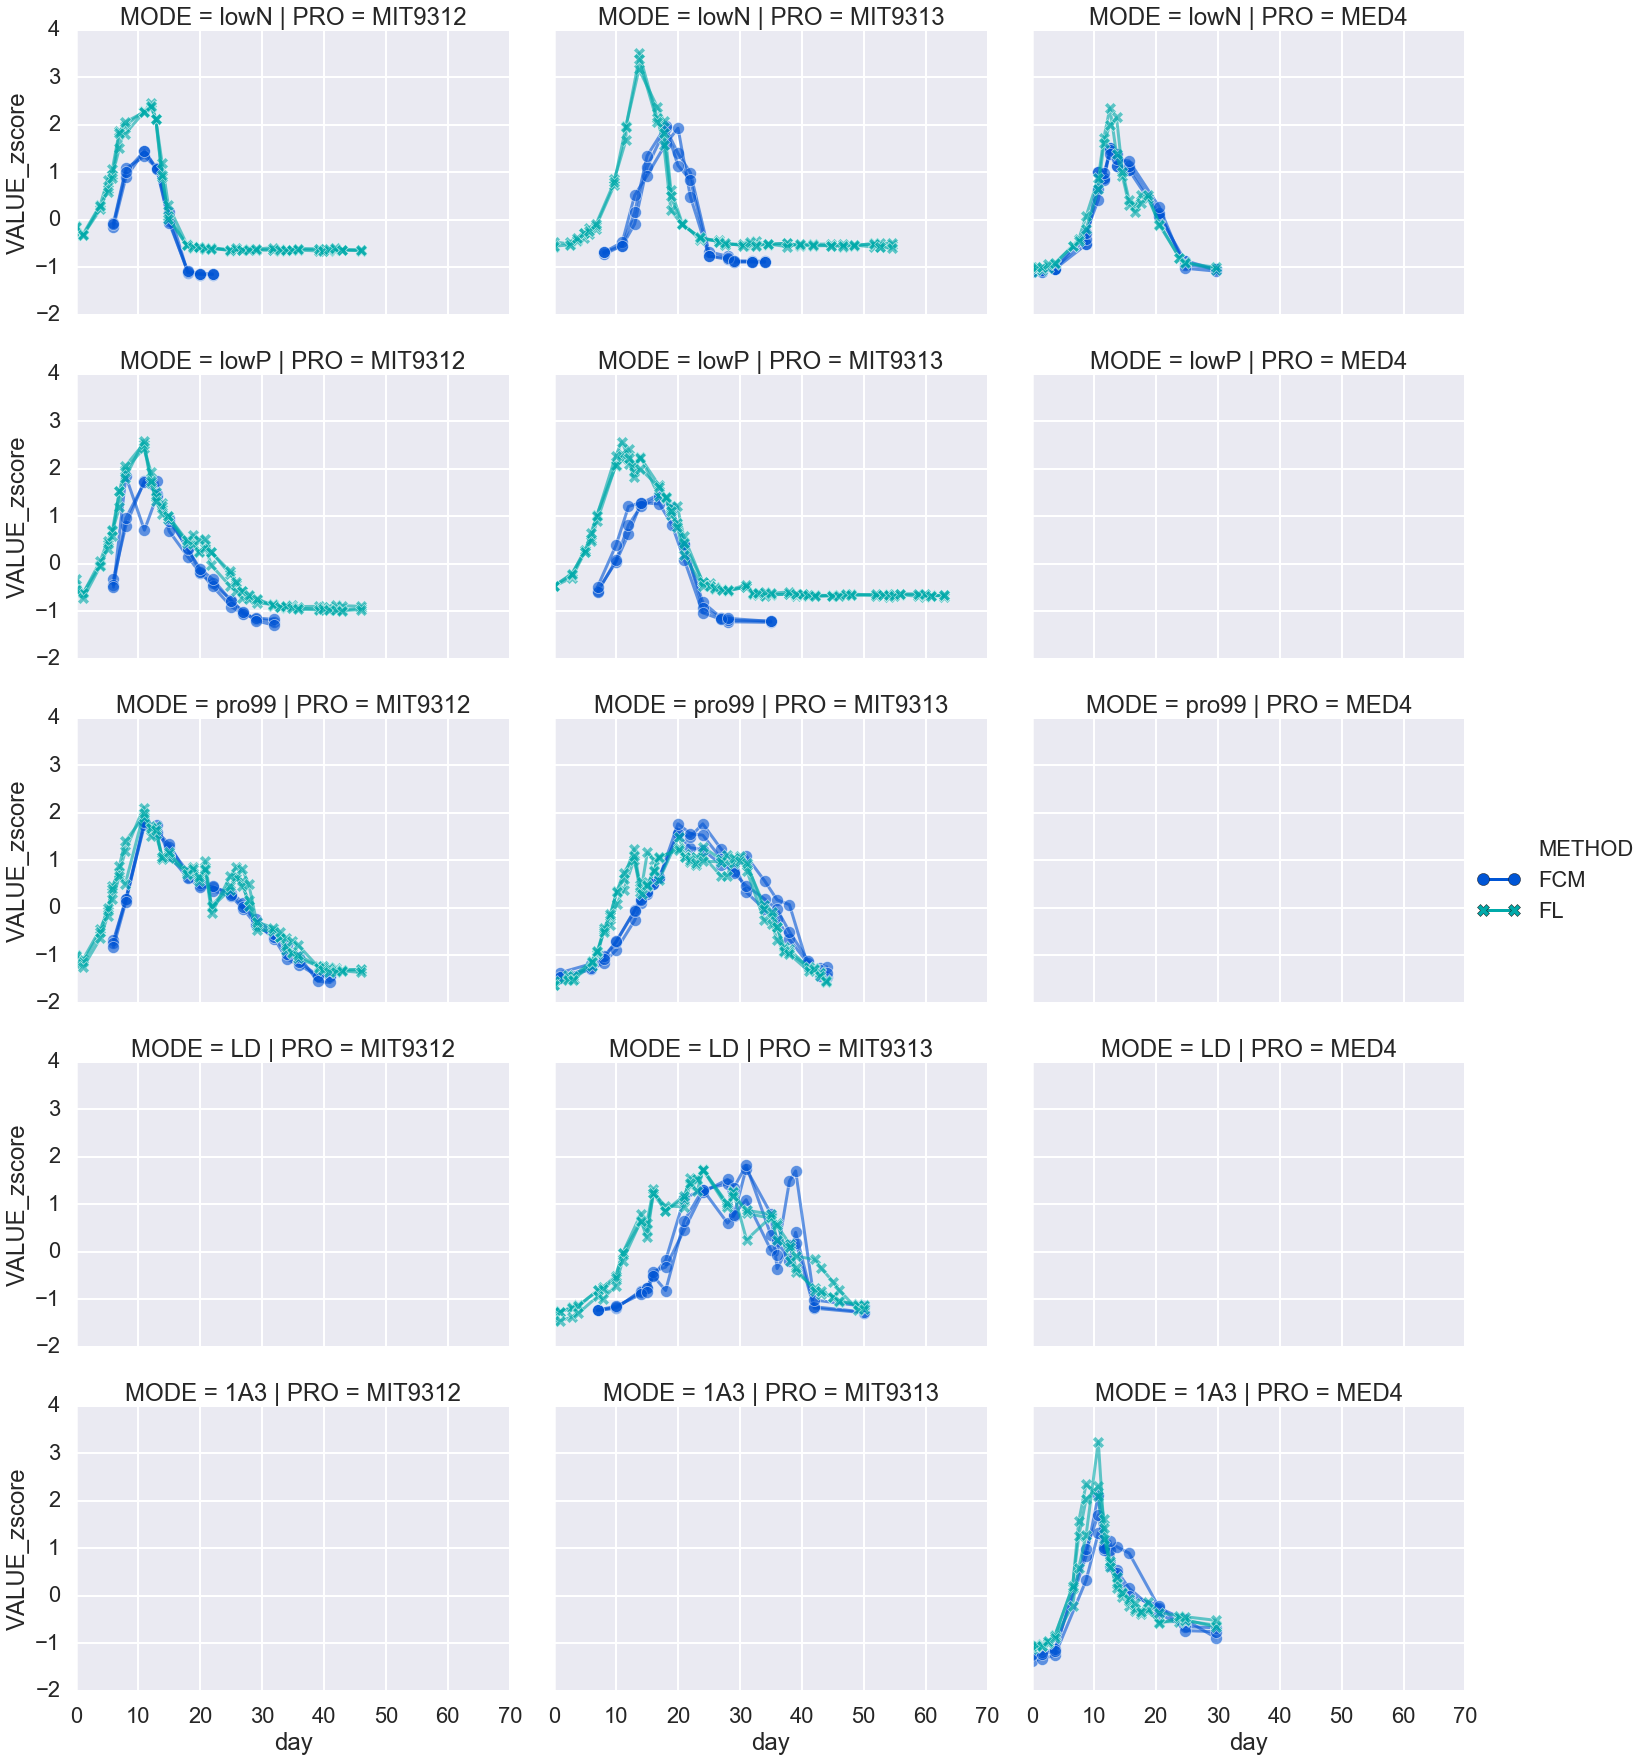

In [24]:
g = sns.relplot(data=df, hue='METHOD', row='MODE',  col='PRO',x='day', y='VALUE_zscore', 
                markers=True, dashes=False,
                alpha=0.6,
                style='METHOD',
            kind='line', estimator=None, units='EXP', palette='winter' , aspect=1.4)


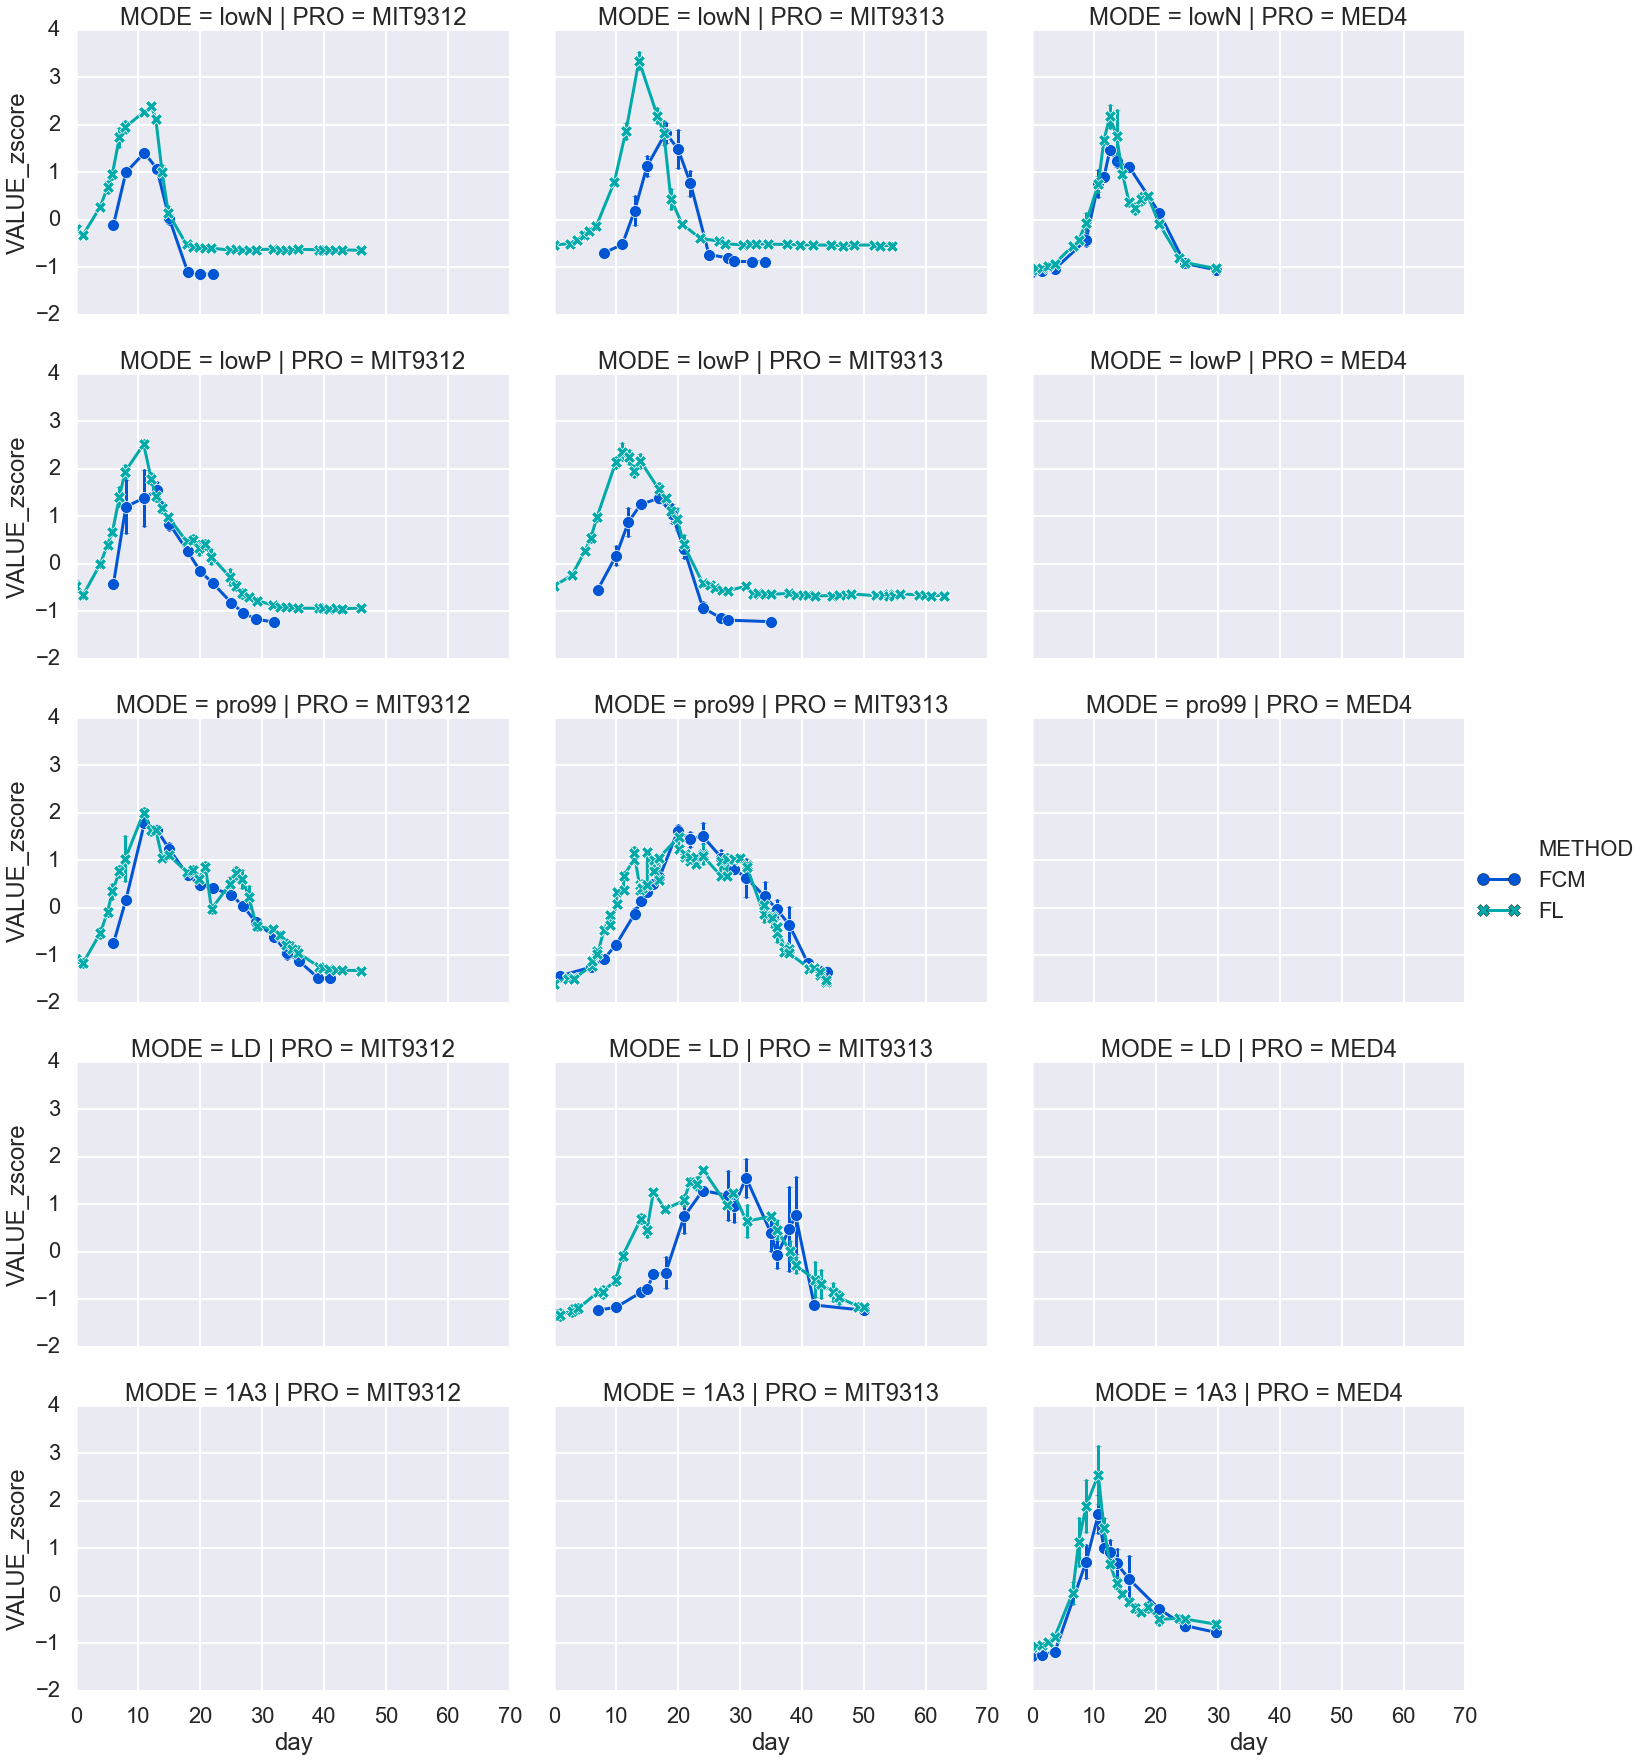

In [25]:
g = sns.relplot(data=df, hue='METHOD', row='MODE',  col='PRO',x='day', y='VALUE_zscore', 
            kind='line', #estimator=None, units='EXP', 
                ci='sd', markers=True,
                dashes=False,
                
                style='METHOD',
                palette='winter' , aspect=1.4,
               err_style='bars')


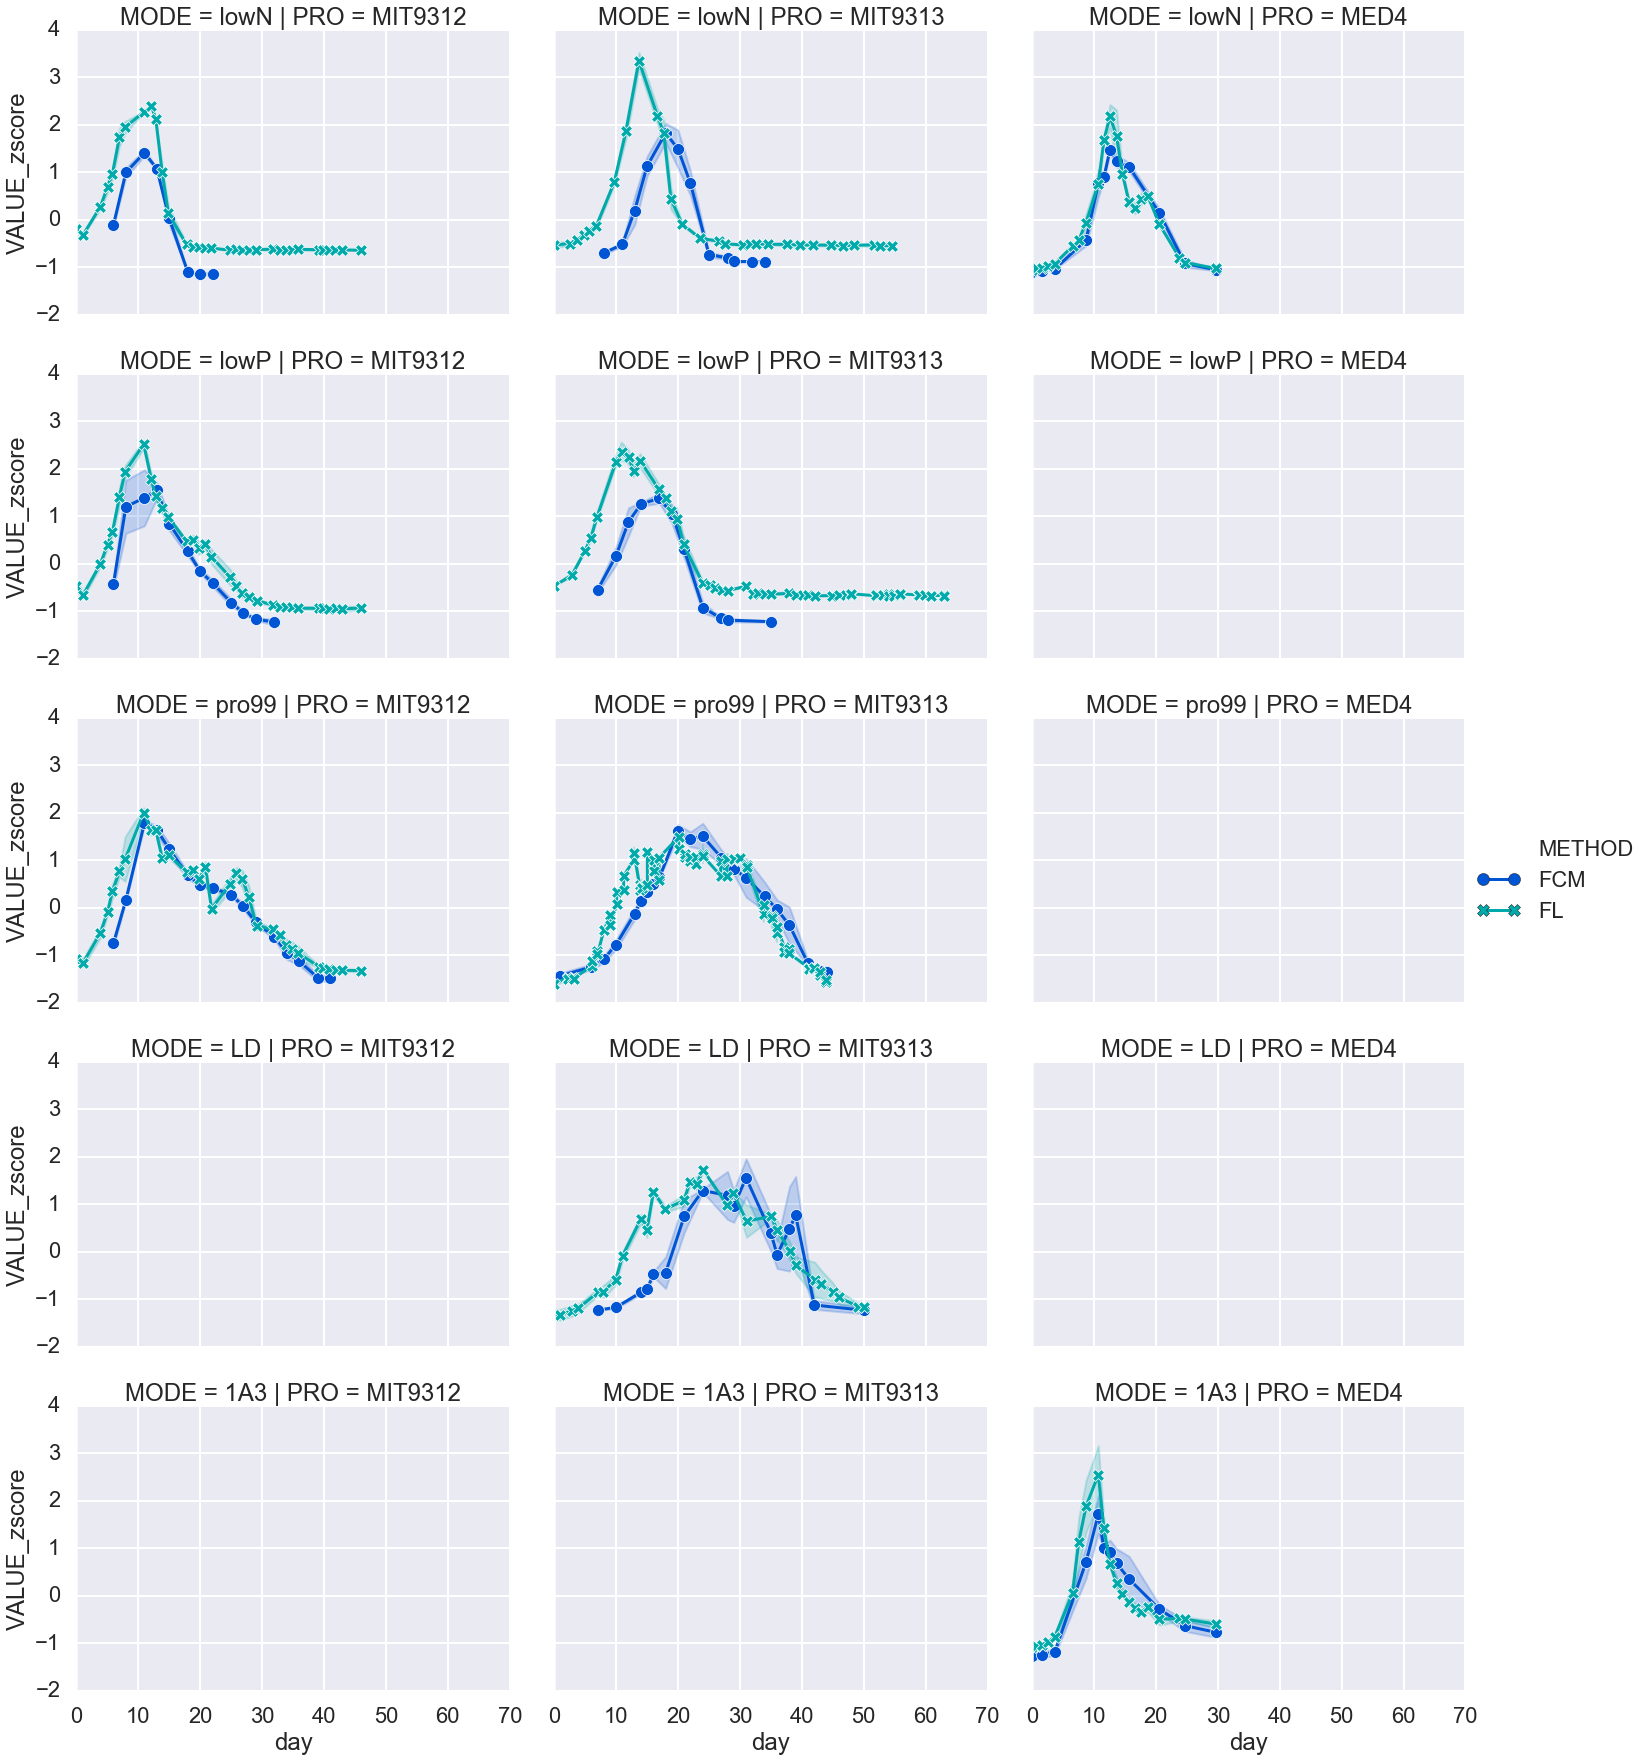

In [26]:
g = sns.relplot(data=df, hue='METHOD', row='MODE',  col='PRO',x='day', y='VALUE_zscore', 
            kind='line', #estimator=None, units='EXP', 
                ci='sd', markers=True, dashes=False,
                
                style='METHOD',
                palette='winter' , aspect=1.4,
               #err_style='bars'
               )


In [27]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE,"PRO, ALT",VALUE_zscore
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",-0.155567
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.889925
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.444952
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.076657
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.167816


In [28]:
d = df.loc[df.EXP=='9312_lowN_1',['day', 'METHOD']]

In [29]:
d.day = d.day.astype('int')

In [30]:
def get_fl_day(df, row):
    x = row['day']
    e = row['EXP']
    
    possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >= x) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >x-1) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        flday =  None
        flval = None
    else: 
        flday =  possible_days[0]
        flval = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day == flday), 'VALUE' ].unique()[0]
    return pd.Series({'fl_day': flday, 'FL': flval})
        
    

d = df.apply(lambda x: get_fl_day(df,x), axis=1)
df = pd.concat([df, d], axis=1)
    
        
    


In [31]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE,"PRO, ALT",VALUE_zscore,fl_day,FL
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",-0.155567,6.96,3.178
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.889925,7.88,3.863
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.444952,10.88,4.302
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.076657,13.86,2.699
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.167816,14.87,1.404


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(0, 300000000.0)

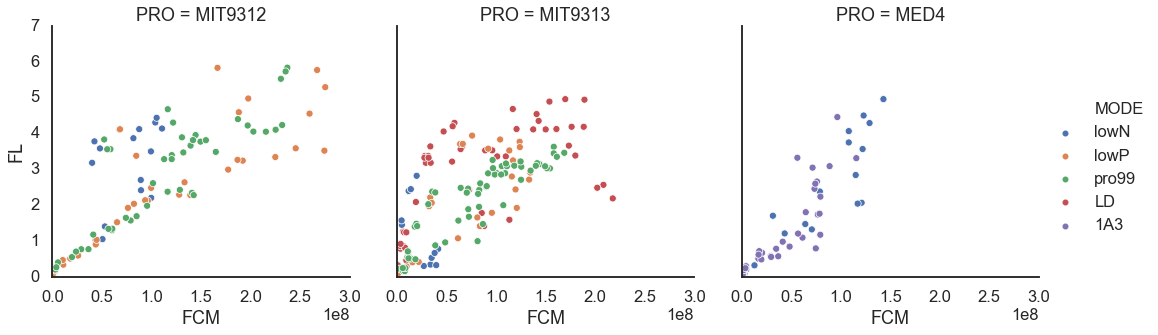

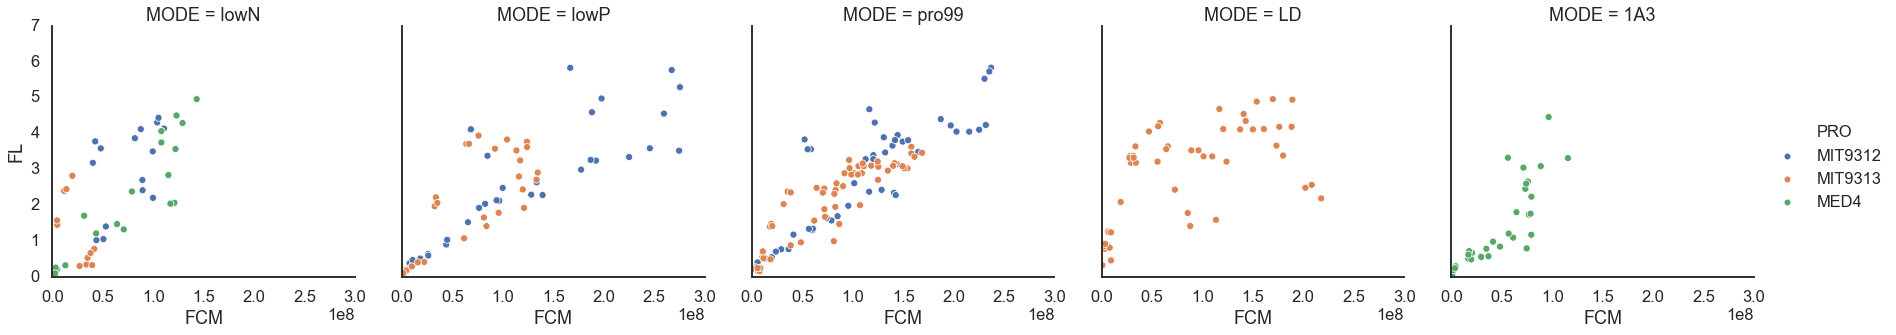

In [32]:
sns.set_context('talk')
sns.set_style('white')
compdf = df.loc[df.METHOD == 'FCM']
compdf.rename(columns={'VALUE': 'FCM'}, inplace=True)
sns.relplot(data=compdf, x='FCM', y='FL', col='PRO', hue='MODE', s=50)
plt.ylim(0)
plt.xlim(0)
sns.relplot(data=compdf, x='FCM', y='FL', col='MODE', hue='PRO', s=50)
plt.ylim(0)
plt.xlim(0)


(0, 300000000.0)

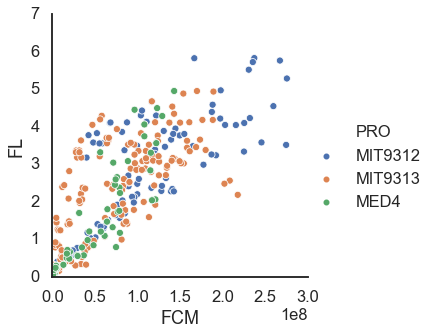

In [33]:
sns.set_context('talk')
sns.set_style('white')
compdf = df.loc[df.METHOD == 'FCM']
compdf.rename(columns={'VALUE': 'FCM'}, inplace=True)
sns.relplot(data=compdf, y='FCM', x='FL', hue='PRO', s=50)
plt.ylim(0)
plt.xlim(0)


(0, 300000000.0)

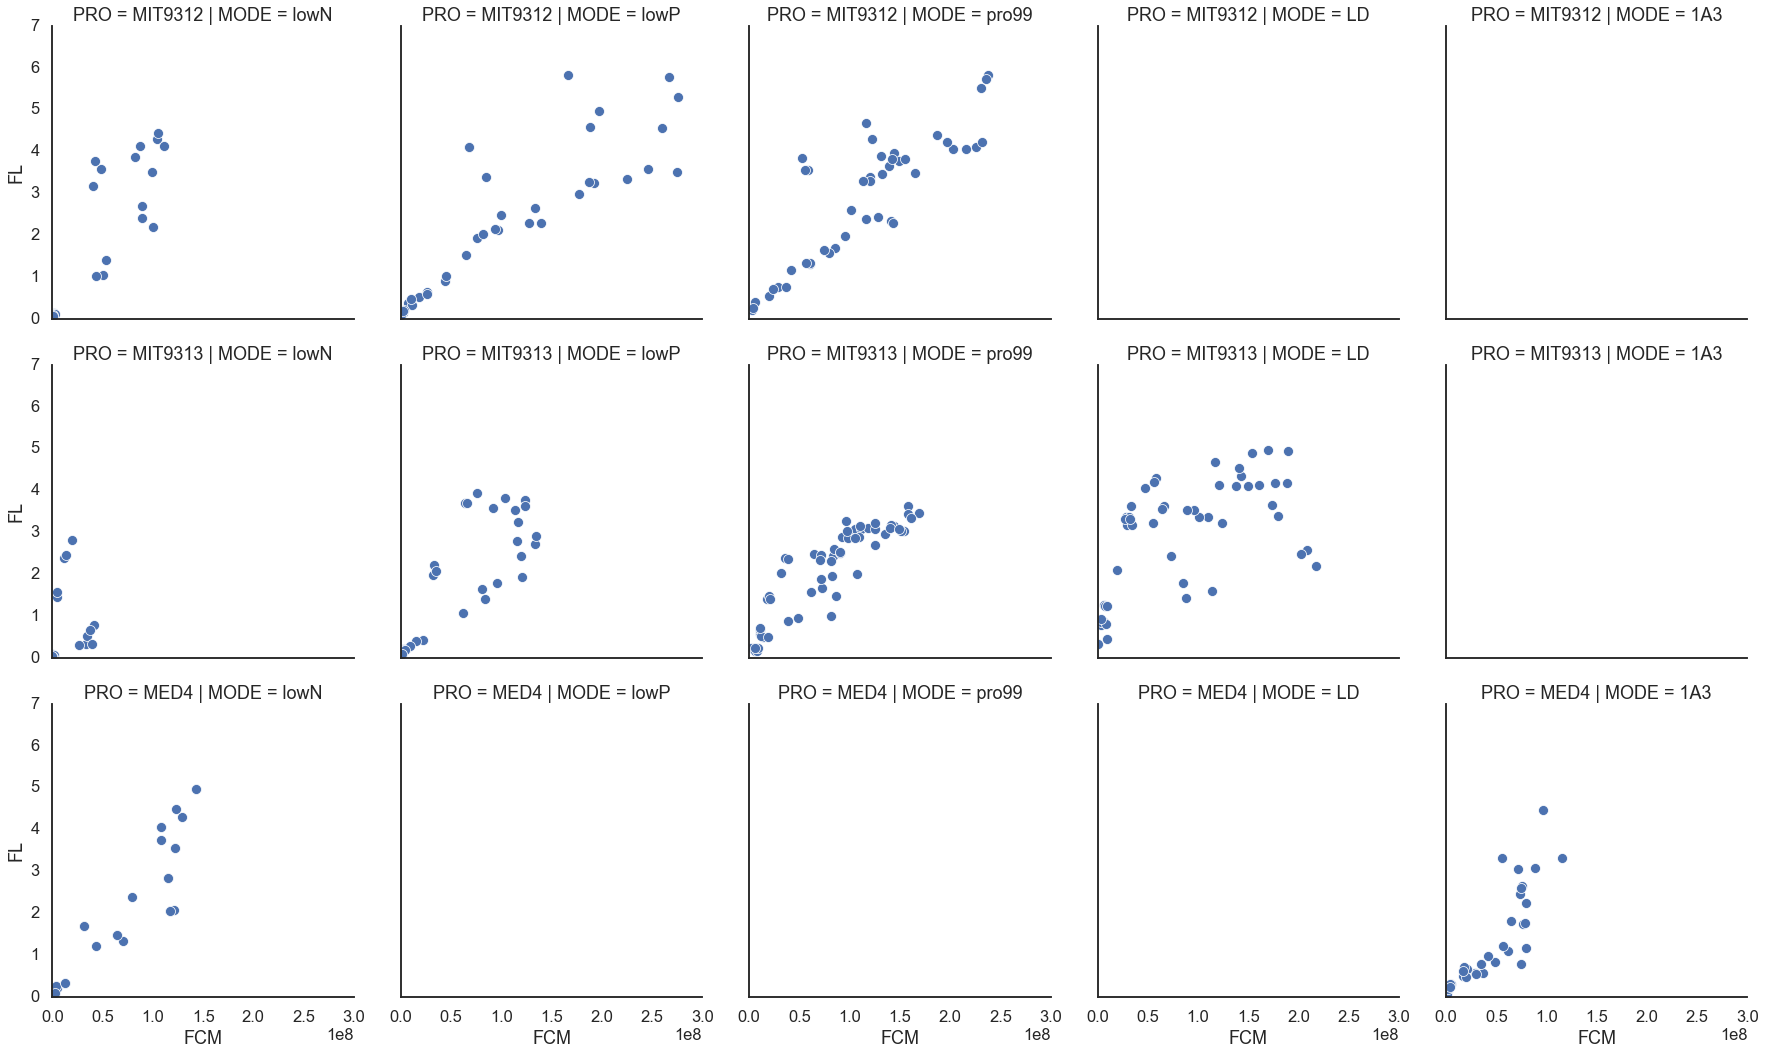

In [34]:
sns.relplot(data=compdf, x='FCM', y='FL', col='MODE', row='PRO', s=100)
plt.ylim(0)
plt.xlim(0)


In [35]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [36]:
compdf.dropna(axis=0, inplace=True)

C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
X = compdf['FL']
y = compdf['FCM']

In [38]:
res = sm.OLS(y, X).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    FCM   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              1935.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):                   4.53e-143
Time:                        14:43:44   Log-Likelihood:                         -6491.9
No. Observations:                 344   AIC:                                  1.299e+04
Df Residuals:                     343   BIC:                                  1.299e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [39]:
compdf.shape

(344, 12)

In [40]:
X1 = sm.add_constant(X)

In [41]:
res = sm.OLS(y, X1).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     643.3
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           1.40e-80
Time:                        14:43:45   Log-Likelihood:                -6491.6
No. Observations:                 344   AIC:                         1.299e+04
Df Residuals:                     342   BIC:                         1.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.778e+06   3.47e+06      0.801      0.4

In [42]:
res.params

const    2.777812e+06
FL       3.378149e+07
dtype: float64

In [43]:
def get_r2(df, add_const=False):
    X = df['FL']
    y = df['FCM']
    if add_const:
        X = sm.add_constant(X)
    res = sm.OLS(y, X).fit()
    
    return pd.Series({'r2': res.rsquared_adj,
            'f_pvalue' : res.f_pvalue, 
            'pvalue':res.pvalues[0],
                      'params': res.params[0],
                      
           })
    
compdf.groupby(['PRO']).apply(get_r2)

,r2,f_pvalue,pvalue,params
PRO,,,,
MED4,0.916859,2.695667e-40,2.695667e-40,3.141783e+07
MIT9312,0.877063,9.901547e-51,9.901547e-51,3.869567e+07
MIT9313,0.815836,5.447234e-62,5.447234e-62,3.195992e+07


In [44]:
compdf.groupby(['PRO', 'MODE']).apply(get_r2)

r2      f_pvalue        pvalue        params
PRO     MODE                                                     
MED4    1A3    0.875738  1.230242e-17  1.230242e-17  2.995207e+07
        lowN   0.935782  1.147799e-22  1.147799e-22  3.215551e+07
MIT9312 lowN   0.883920  1.870587e-12  1.870587e-12  2.333400e+07
        lowP   0.885014  3.149890e-18  3.149890e-18  4.498062e+07
        pro99  0.929202  6.905734e-29  6.905734e-29  3.959920e+07
MIT9313 LD     0.747434  8.989548e-17  8.989548e-17  2.918033e+07
        lowN   0.220859  1.825374e-02  1.825374e-02  9.262822e+06
        lowP   0.860315  1.923851e-15  1.923851e-15  3.125856e+07
        pro99  0.941079  3.425551e-38  3.425551e-38  3.849353e+07

In [45]:
res.f_pvalue, res.pvalues[0]

(1.4006800386206603e-80, 0.42390419543896407)

In [46]:
f = lambda x: get_r2(x, add_const=True)
print(f(compdf))
print(compdf.groupby(['PRO']).apply(f))
compdf.groupby(['PRO', 'MODE']).apply(f)

r2          6.518753e-01
f_pvalue    1.400680e-80
pvalue      4.239042e-01
params      2.777812e+06
dtype: float64
               r2      f_pvalue    pvalue        params
PRO                                                    
MED4     0.825940  1.684079e-28  0.017421  7.919504e+06
MIT9312  0.687689  9.201312e-29  0.688550  2.942393e+06
MIT9313  0.552993  2.404224e-30  0.519497  3.561536e+06


r2      f_pvalue    pvalue        params
PRO     MODE                                                 
MED4    1A3    0.723804  3.042304e-11  0.010795  1.185176e+07
        lowN   0.864050  1.641981e-16  0.233737  5.921705e+06
MIT9312 lowN   0.740666  4.187948e-08  0.362243  6.293943e+06
        lowP   0.708284  7.780770e-11  0.747728  4.554239e+06
        pro99  0.764862  2.804901e-16  0.802106  2.491747e+06
MIT9313 LD     0.340517  4.182379e-06  0.973996 -5.987091e+05
        lowN  -0.023614  4.632676e-01  0.022144  1.148816e+07
        lowP   0.658359  6.170905e-09  0.290214  8.872746e+06
        pro99  0.803413  2.296304e-22  0.136214 -9.659891e+06

In [47]:
f = lambda x: get_r2(x, add_const=False)
print(f(compdf))
print(compdf.groupby(['PRO']).apply(f))
compdf.groupby(['PRO', 'MODE']).apply(f)


r2           8.489818e-01
f_pvalue    4.527550e-143
pvalue      4.527550e-143
params       3.464125e+07
dtype: float64
               r2      f_pvalue        pvalue        params
PRO                                                        
MED4     0.916859  2.695667e-40  2.695667e-40  3.141783e+07
MIT9312  0.877063  9.901547e-51  9.901547e-51  3.869567e+07
MIT9313  0.815836  5.447234e-62  5.447234e-62  3.195992e+07


r2      f_pvalue        pvalue        params
PRO     MODE                                                     
MED4    1A3    0.875738  1.230242e-17  1.230242e-17  2.995207e+07
        lowN   0.935782  1.147799e-22  1.147799e-22  3.215551e+07
MIT9312 lowN   0.883920  1.870587e-12  1.870587e-12  2.333400e+07
        lowP   0.885014  3.149890e-18  3.149890e-18  4.498062e+07
        pro99  0.929202  6.905734e-29  6.905734e-29  3.959920e+07
MIT9313 LD     0.747434  8.989548e-17  8.989548e-17  2.918033e+07
        lowN   0.220859  1.825374e-02  1.825374e-02  9.262822e+06
        lowP   0.860315  1.923851e-15  1.923851e-15  3.125856e+07
        pro99  0.941079  3.425551e-38  3.425551e-38  3.849353e+07

In [62]:
d = df.loc[df.METHOD == 'FL']
def get_max_day(x):
    maxidx = x['VALUE'].idxmax()
    maxday = x.loc[maxidx]['day']
    return maxday
max_days = d.groupby('EXP').apply(get_max_day)



In [63]:
compdf.head()

,day,FCM,EXP,METHOD,PRO,ALT,Sample,MODE,"PRO, ALT",VALUE_zscore,fl_day,FL
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",-0.155567,6.96,3.178
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.889925,7.88,3.863
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.444952,10.88,4.302
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",1.076657,13.86,2.699
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN,"MIT9312, N/A",0.167816,14.87,1.404


In [72]:
decline_compdf = compdf.loc[compdf['day'] >= max_days[compdf['EXP']].values]

In [70]:
max_days[compdf['EXP']]

EXP
9312_lowN_1    12.09
9312_lowN_1    12.09
9312_lowN_1    12.09
9312_lowN_1    12.09
9312_lowN_1    12.09
               ...  
MED4_1A3_3     10.70
MED4_1A3_3     10.70
MED4_1A3_3     10.70
MED4_1A3_3     10.70
MED4_1A3_3     10.70
Length: 344, dtype: float64

In [80]:
f = lambda x: get_r2(x, add_const=False)
print(f(decline_compdf))
print(decline_compdf.groupby(['PRO']).apply(f))
decline_compdf.groupby(['PRO', 'MODE']).apply(f)


r2           9.212645e-01
f_pvalue    3.605859e-124
pvalue      3.605859e-124
params       4.223913e+07
dtype: float64
               r2      f_pvalue        pvalue        params
PRO                                                        
MED4     0.901249  2.012100e-21  2.012100e-21  3.361863e+07
MIT9312  0.950689  3.348497e-58  3.348497e-58  4.573085e+07
MIT9313  0.903285  1.090857e-49  1.090857e-49  4.082343e+07


r2      f_pvalue        pvalue        params
PRO     MODE                                                     
MED4    1A3    0.854091  7.048448e-11  7.048448e-11  3.294855e+07
        lowN   0.921958  1.720929e-10  1.720929e-10  3.396310e+07
MIT9312 lowN   0.978676  2.613758e-13  2.613758e-13  3.828859e+07
        lowP   0.928956  2.065654e-18  2.065654e-18  5.051132e+07
        pro99  0.974810  1.284699e-34  1.284699e-34  4.358359e+07
MIT9313 LD     0.840041  4.600983e-12  4.600983e-12  3.971388e+07
        lowN   0.923783  1.066767e-07  1.066767e-07  6.040100e+07
        lowP   0.952251  1.417524e-17  1.417524e-17  4.081853e+07
        pro99  0.971991  4.582546e-25  4.582546e-25  4.245195e+07

In [81]:
decline_compdf.groupby(['MODE']).apply(f)


,r2,f_pvalue,pvalue,params
MODE,,,,
1A3,0.854091,7.048448e-11,7.048448e-11,3.294855e+07
LD,0.840041,4.600983e-12,4.600983e-12,3.971388e+07
lowN,0.928305,1.888217e-26,1.888217e-26,3.490944e+07
lowP,0.926813,1.492437e-32,1.492437e-32,4.750996e+07
pro99,0.974268,3.457089e-59,3.457089e-59,4.327666e+07


(0, 300000000.0)

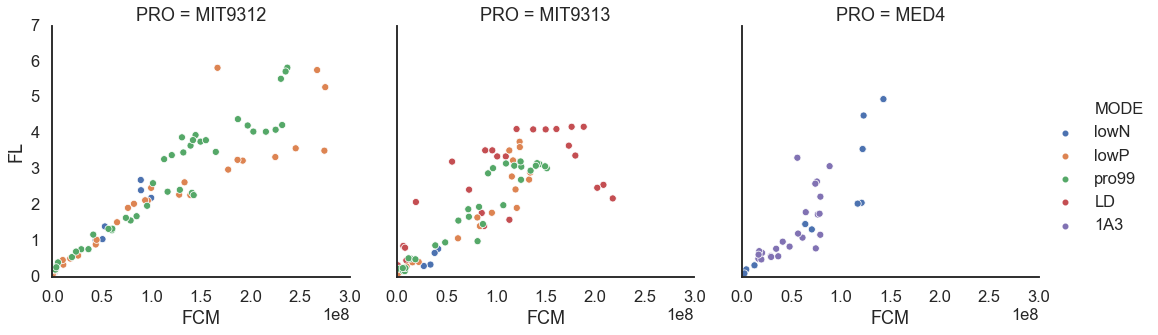

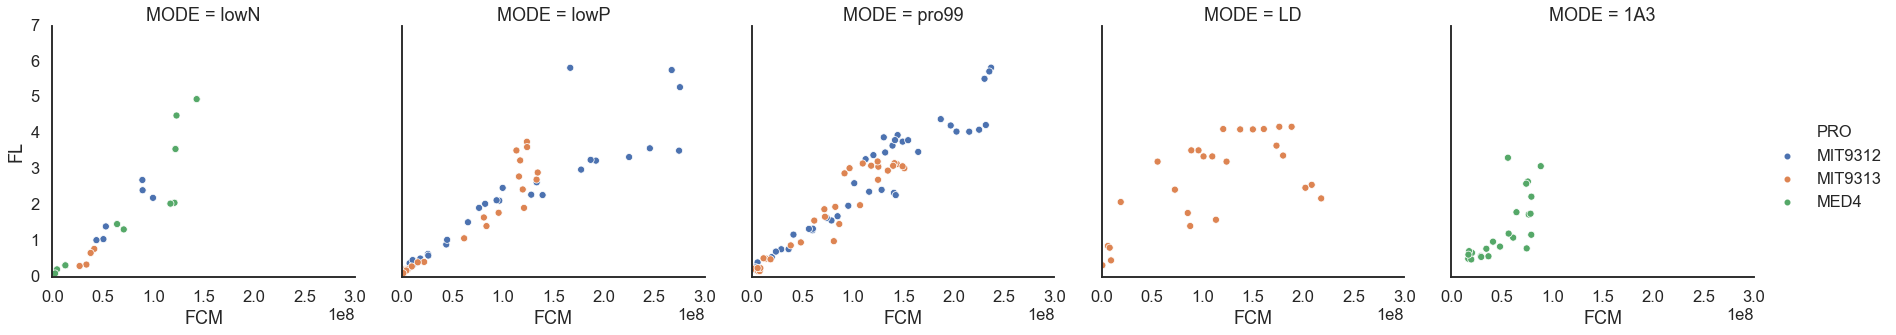

In [75]:
sns.set_context('talk')
sns.set_style('white')
sns.relplot(data=decline_compdf, x='FCM', y='FL', col='PRO', hue='MODE', s=50)
plt.ylim(0)
plt.xlim(0)
sns.relplot(data=decline_compdf, x='FCM', y='FL', col='MODE', hue='PRO', s=50)
plt.ylim(0)
plt.xlim(0)


Text(0.5, 1, 'FL vs FCM decline only')

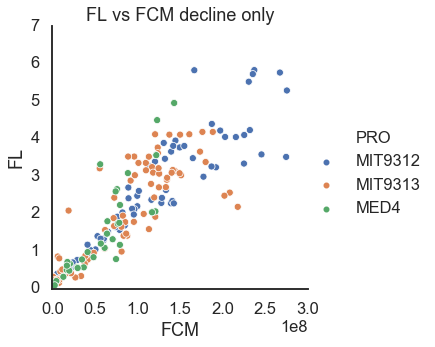

In [79]:
sns.set_context('talk')
sns.set_style('white')
sns.relplot(data=decline_compdf, x='FCM', y='FL', hue='PRO', s=50)
plt.ylim(0)
plt.xlim(0)
plt.title('FL vs FCM decline only')

(0, 300000000.0)

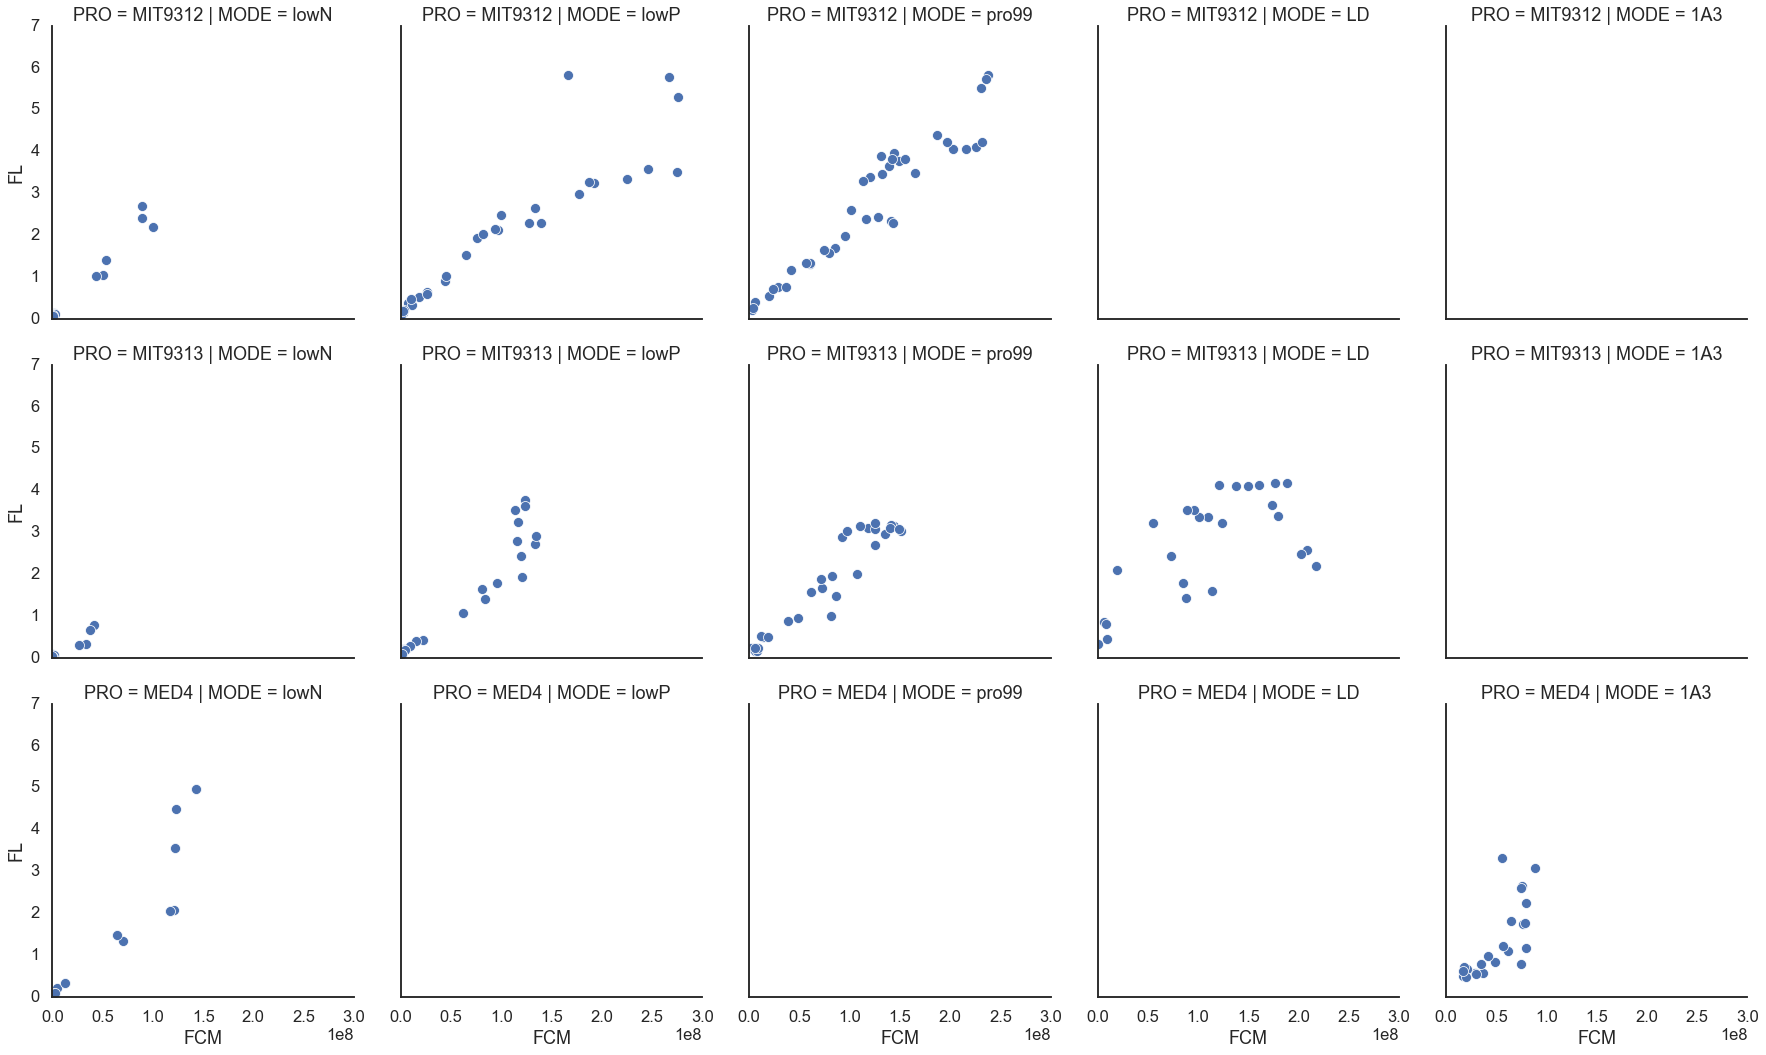

In [77]:
sns.relplot(data=decline_compdf, x='FCM', y='FL', col='MODE', row='PRO', s=100)
plt.ylim(0)
plt.xlim(0)
